In [1]:
import numpy as np
import math
import h5py
import time
import itertools
from tqdm import tqdm
from tqdm import trange
from multiprocessing import Pool, cpu_count

import pandas as pd
import _pickle as cPickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Import NN models from file
from NNmodels import DNN_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras_tqdm import TQDMNotebookCallback
from keras.models import load_model

from skimage.transform import iradon

from variables_historical_sample_S157 import list_tth, list_db, list_icor, list_combination, length_list, dict_ph, n_ph
from functions_historical_sample_S157 import MP_intermediate, MP_intermediate_1, MP_intermediate_2, MP_intermediate_3, MP_Pattern_rebuilding, Rwp

2024-03-04 17:27:45.253485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 17:27:45.357458: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 17:27:45.360783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-04 17:27:45.360796: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Dataset generation (skip if already done)

# =============================================================================
# Main code here (if __name__ == "__main__": enclosing required for 
# proper multiprocessing functioning)
# =============================================================================
if __name__ == "__main__":
    
    sizeTest = 50 # Number of diagrams per combination (100K pattern = 9000 for 1/11, 1800 for 2/11, 600 for 3/11, 50 for all)
## Add the next line, if MP_intermediate_1/2/3 is chosen instead   
#     list_combination = [x for x in itertools.combinations(range(11), 1/2/3)] # 11 choose 1/2/3

    # =============================================================================
    #      Starting the dataset creation
    #      Multi processing routine here
    # =============================================================================
    n_processes = cpu_count()
    print("Starting drx pattern generation on "+str(n_processes)+" CPUs")
    
    args = zip(itertools.repeat(list_tth), itertools.repeat(list_db), 
                itertools.repeat(list_icor), itertools.repeat(sizeTest), 
                list_combination)
    
    if 1:
        start = time.time()
        with Pool(processes=n_processes) as proc_pool:
            # Modify MP_intermediate if necessary
            results = proc_pool.starmap(MP_intermediate, tqdm(args, total=len(list_combination)), chunksize=1)
        # =============================================================================
        #     Concatenate the results to form one numpy array
        # =============================================================================
        dataset = np.empty((0, length_list+3*n_ph), float)
        for res in results:
            dataset = np.append(dataset, res, axis=0)

    if 1:    
        # =============================================================================
        #     Save and print
        ## NPY files more than 4GB are difficult to 
        ## save in standard computers, hence using pickle
        # =============================================================================
        with open("datasetS157_"+str(sizeTest*len(list_combination)//1000)+"K.pickle", "wb") as output_file:
            cPickle.dump([dataset], output_file)
        print("Shape du dataset :", dataset.shape)
        # Print the creation time of the dataset
        end = time.time()
        tps = int(end - start)
        print("Temps : ", tps//60, 'minutes', tps%60, 'secondes')
        
        # Print the number of error in the dataset
        print("Nombre d'erreur :", np.isnan(dataset).sum())

## Visualization of the data

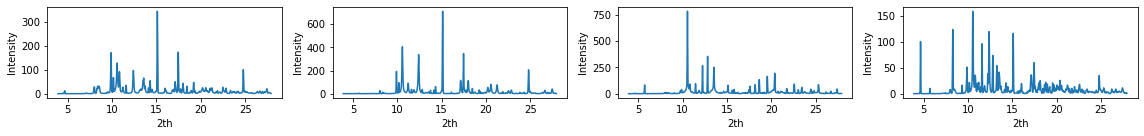

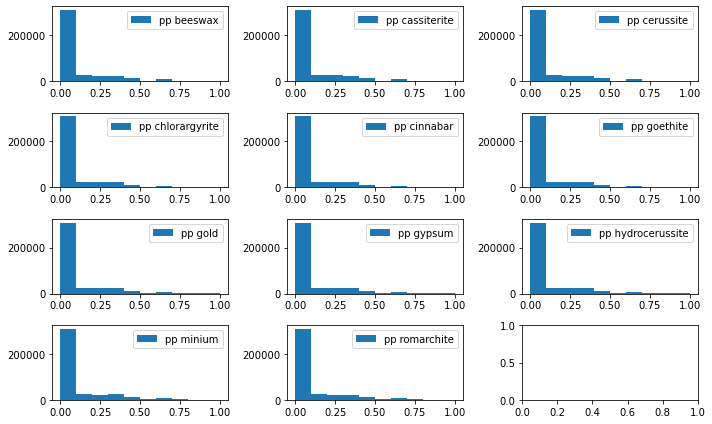

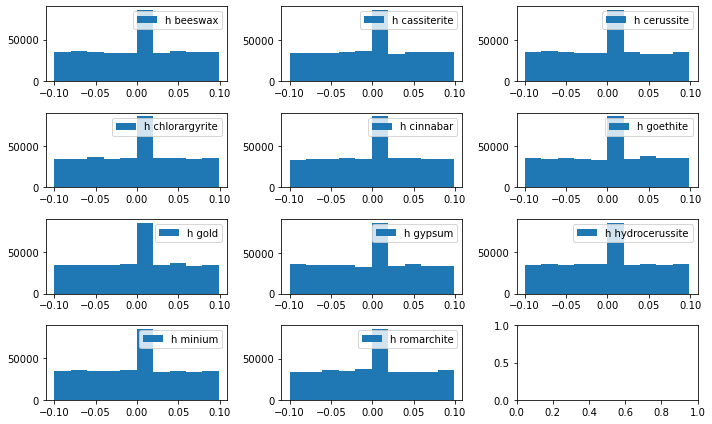

In [2]:
with open("dataset_historical_sample_S157.pickle", "rb") as input_file:
    dataset = cPickle.load(input_file)[0]

# Check some patterns to see if everything is ok
fig,axs = plt.subplots(1,4,figsize=(16,2))
for i,ax in enumerate(axs.flatten()):
    ind = np.random.randint(0, dataset.shape[0])
    ax.plot(list_tth, dataset[ind,:2150], zorder=2)
    ax.set_ylabel('Intensity')
    ax.set_xlabel('2th')
plt.tight_layout()
plt.show()

# Check the phase fraction distribution
fig,axs = plt.subplots(4,3,figsize=(10,6))
for i in range(n_ph):
    axs=axs.flatten()
    axs[i].hist(dataset[:, 2150+i], bins=10, label=f"pp {dict_ph[i]}")
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Same for h
fig,axs = plt.subplots(4,3,figsize=(10,6))
for i in range(n_ph):
    axs=axs.flatten()
    axs[i].hist(dataset[:, 2150+2*n_ph+i], bins=10, label=f"h {dict_ph[i]}")
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

## Data preprocessing before input into NN

In [3]:
if __name__ == "__main__":
                
    X = dataset[:,:-3*n_ph]
    
    # Predctions only on phase fractions, y_pp, and phase positions, y_h
    y_pp = dataset[:,-3*n_ph:-2*n_ph]
    y_h = dataset[:, -n_ph:]
    y = np.concatenate((y_pp, y_h), axis=1) # single ndarray for both y_pp and y_h
    
    # =============================================================================
    #     Split data
    # =============================================================================
    random_split_seed = 11
    test_size = 0.2
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_split_seed)
       
    # =============================================================================
    #     Data normalisation
    # =============================================================================
    normalize_data = True
    if normalize_data:
        # Local normalization of each XRD pattern by their maximum
        X_train_rowmax = np.reshape(np.max(X_train, axis=1), (len(X_train),1))
        X_val_rowmax =  np.reshape(np.max(X_val, axis=1), (len(X_val),1))
        X_train = X_train / X_train_rowmax
        X_val = X_val / X_val_rowmax
        
        # Keras standard normalization
        # sc = StandardScaler()
        # X_train = sc.fit_transform(X_train)
        # X_val = sc.transform(X_val)

    # =============================================================================
    #     Output normalisation
    # =============================================================================
    # Offset added to h : no negative values in order to use ReLU as output function
    y_train[:, n_ph:2*n_ph] = y_train[:, n_ph:2*n_ph] + 0.1
    y_val[:, n_ph:2*n_ph] = y_val[:, n_ph:2*n_ph] + 0.1
    
    ## to increase loss values 
    # (smaller value of output may lead to low derivative in loss) --> the model will stop learning
    factor_multiplier_pp = 1000
    rounding_pp = 0
    y_train[:,:n_ph] = np.round(y_train[:,:n_ph] * factor_multiplier_pp, rounding_pp)
    y_val[:,:n_ph] = np.round(y_val[:,:n_ph] * factor_multiplier_pp, rounding_pp)
    
    factor_multiplier_h = 5000
    rounding_h = 0
    y_train[:,n_ph:2*n_ph] = np.round(y_train[:,n_ph:2*n_ph] * factor_multiplier_h, rounding_h)
    y_val[:,n_ph:2*n_ph] = np.round(y_val[:,n_ph:2*n_ph] * factor_multiplier_h, rounding_h)

## Neural network training

Epoch 1/20
1248/1248 [==============================] - 16s 13ms/step - loss: 23.7370 - mse: 4961.9390 - mae: 23.7370 - val_loss: 3.4462 - val_mse: 88.1999 - val_mae: 3.4462
Epoch 2/20
1248/1248 [==============================] - 15s 12ms/step - loss: 2.1931 - mse: 36.4132 - mae: 2.1931 - val_loss: 1.5434 - val_mse: 15.8088 - val_mae: 1.5434
Epoch 3/20
1248/1248 [==============================] - 15s 12ms/step - loss: 1.3058 - mse: 11.0678 - mae: 1.3058 - val_loss: 1.1115 - val_mse: 7.8155 - val_mae: 1.1115
Epoch 4/20
1248/1248 [==============================] - 15s 12ms/step - loss: 1.0342 - mse: 6.5684 - mae: 1.0342 - val_loss: 0.9531 - val_mse: 5.3605 - val_mae: 0.9531
Epoch 5/20
1248/1248 [==============================] - 15s 12ms/step - loss: 0.9036 - mse: 4.8000 - mae: 0.9036 - val_loss: 0.8752 - val_mse: 4.2067 - val_mae: 0.8752
Epoch 6/20
1248/1248 [==============================] - 15s 12ms/step - loss: 0.8256 - mse: 3.8636 - mae: 0.8256 - val_loss: 0.8098 - val_mse: 3.4880 -

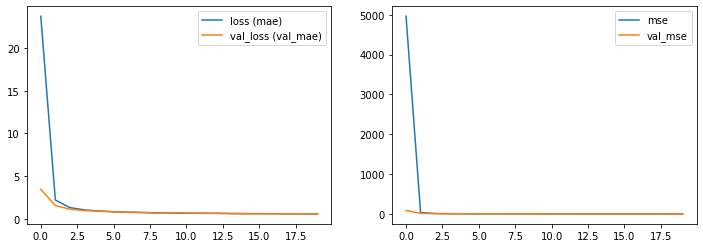

In [9]:
# lets take only phase fraction first
if __name__ == "__main__":
    
    y_train_pp = y_train[:,:n_ph]
    y_val_pp = y_val[:,:n_ph]
    
    # =============================================================================
    #     Build a model from NNmodels.py
    # =============================================================================
    model_pp = DNN_model(  
                        len(X_train[0]),
                        layer_activation="tanh",
                        output_activation="relu",
                        dropout=0,
                        DNN_layers=1,
                        DNN_filters=[len(X_train[0]), len(X_train[0])//2, len(X_train[0])//3],
                        output_neurons=n_ph,
                        learning_rate=0.001,
                        optimizer="adam",
                        loss= "mae")
    # model.summary()
    
    ## some callback functions to stop and save model
    es_pp = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    ms_pp = ModelCheckpoint("best_val_loss_model_pp.h5", monitor='val_loss', 
                         mode='min', save_best_only=True)
    
    # =============================================================================
    #     Hyperparameters definition for training
    # =============================================================================
    start = time.time()
    history = model_pp.fit(X_train,
                        y_train_pp,
                        epochs          = 20,
                        batch_size      = 256,
                        verbose         = 1,
                        validation_data = (X_val, y_val_pp),
                        callbacks       = [es_pp, ms_pp])
    
    end = time.time()
    tps = int(end - start)
    print("Learning time: ", tps//60, 'minutes', tps%60, 'seconds')
    
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="loss (mae)")
    plt.plot(history.history['val_loss'], label="val_loss (val_mae)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label="mse")
    plt.plot(history.history['val_mse'], label="val_mse")
    plt.legend()
    plt.show()
    
    # ## Step 6 : Evaluate
    # Model prediction on train dataset
    # y_predict = model.predict(X_val[:1,:])
    # y_predict = y_predict.astype(np.int64)
    # print("Ground Truth", y_val[0,:])
    # print("Prediction", y_predict[0, :])
    # print("Difference", sum(abs(y_predict[0, :] - y_val[0,:])))

2496/2496 [==============================] - 6s 2ms/step


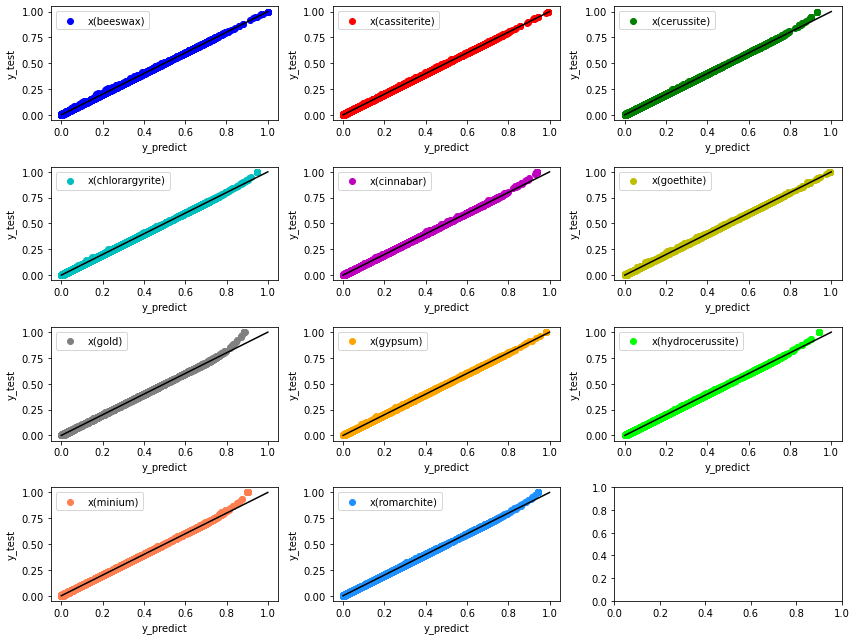

In [10]:
# Prediction of pp on val data
model_pp = load_model('best_val_loss_model_pp.h5')
y_predict_pp = model_pp.predict( X_val )

colors = ['b', 'r', 'g', 'c', 'm', 'y', 'gray', 'orange', 'lime', 'coral', 'dodgerblue']
fig,axs = plt.subplots(4,3,figsize=(12,9))
for i in range(n_ph):
    axs = axs.flatten()
    axs[i].plot([0,1], [0,1], color="k")
    axs[i].scatter(y_predict_pp[:, i] / factor_multiplier_pp, 
                   y_val[:, i] / factor_multiplier_pp, 
                   color=colors[i],
                   label=f"x({dict_ph[i]})")
    axs[i].set_ylabel('y_test')
    axs[i].set_xlabel('y_predict')
    axs[i].legend()
plt.tight_layout()
plt.show()

Epoch 1/20
1248/1248 [==============================] - 16s 13ms/step - loss: 193.7588 - mse: 61878.3047 - mae: 193.7588 - val_loss: 160.9603 - val_mse: 46921.8750 - val_mae: 160.9603
Epoch 2/20
1248/1248 [==============================] - 15s 12ms/step - loss: 148.2911 - mse: 42110.0625 - mae: 148.2911 - val_loss: 136.0841 - val_mse: 37806.7383 - val_mae: 136.0841
Epoch 3/20
1248/1248 [==============================] - 15s 12ms/step - loss: 128.4911 - mse: 35100.4531 - mae: 128.4911 - val_loss: 120.8061 - val_mse: 32581.2910 - val_mae: 120.8061
Epoch 4/20
1248/1248 [==============================] - 15s 12ms/step - loss: 116.0922 - mse: 30939.8770 - mae: 116.0922 - val_loss: 111.3776 - val_mse: 29361.1367 - val_mae: 111.3776
Epoch 5/20
1248/1248 [==============================] - 15s 12ms/step - loss: 107.7393 - mse: 28145.9102 - mae: 107.7393 - val_loss: 102.5555 - val_mse: 26680.1016 - val_mae: 102.5555
Epoch 6/20
1248/1248 [==============================] - 15s 12ms/step - loss: 10

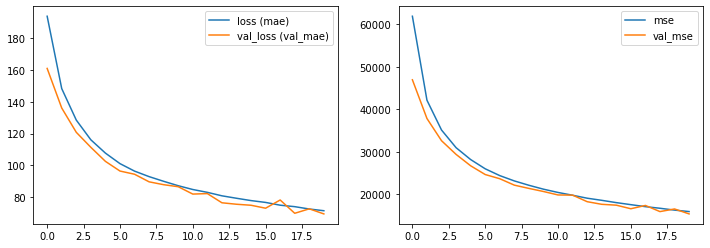

In [11]:
# Now let's take phase position
if __name__ == "__main__":
    
    y_train_h = y_train[:,n_ph:2*n_ph]
    y_val_h = y_val[:,n_ph:2*n_ph]
    
    # ## Step 4 : Build a model
    model_h = DNN_model(  
                        len(X_train[0]),
                        layer_activation="relu",
                        output_activation="relu",
                        dropout=0,
                        DNN_layers=1,
                        DNN_filters=[len(X_train[0]), len(X_train[0])//2, len(X_train[0])//3],
                        output_neurons=n_ph,
                        learning_rate=0.01,
                        optimizer="adam",
                        loss= "mae")
    # model.summary()
    
    ## some callback functions to stop and save model
    es_h = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    ms_h = ModelCheckpoint("best_val_loss_model_h.h5", monitor='val_loss', 
                         mode='min', save_best_only=True)
    
    # ### Step 5 : Train it
    start = time.time()
    history = model_h.fit(X_train,
                        y_train_h,
                        epochs          = 20,
                        batch_size      = 256,
                        verbose         = 1,
                        validation_data = (X_val, y_val_h),
                        callbacks       = [es_h, ms_h])
    
    end = time.time()
    tps = int(end - start)
    print("Temps d'apprentissage : ", tps//60, 'minutes', tps%60, 'secondes')
    
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="loss (mae)")
    plt.plot(history.history['val_loss'], label="val_loss (val_mae)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label="mse")
    plt.plot(history.history['val_mse'], label="val_mse")
    plt.legend()
    plt.show()
    
    # ## Step 6 : Evaluate
    # Model prediction on train dataset
    # y_predict = model.predict(X_val[:1,:])
    # y_predict = y_predict.astype(np.int64)
    # print("Ground Truth", y_val[0,:])
    # print("Prediction", y_predict[0, :])
    # print("Difference", sum(abs(y_predict[0, :] - y_val[0,:])))

2496/2496 [==============================] - 5s 2ms/step


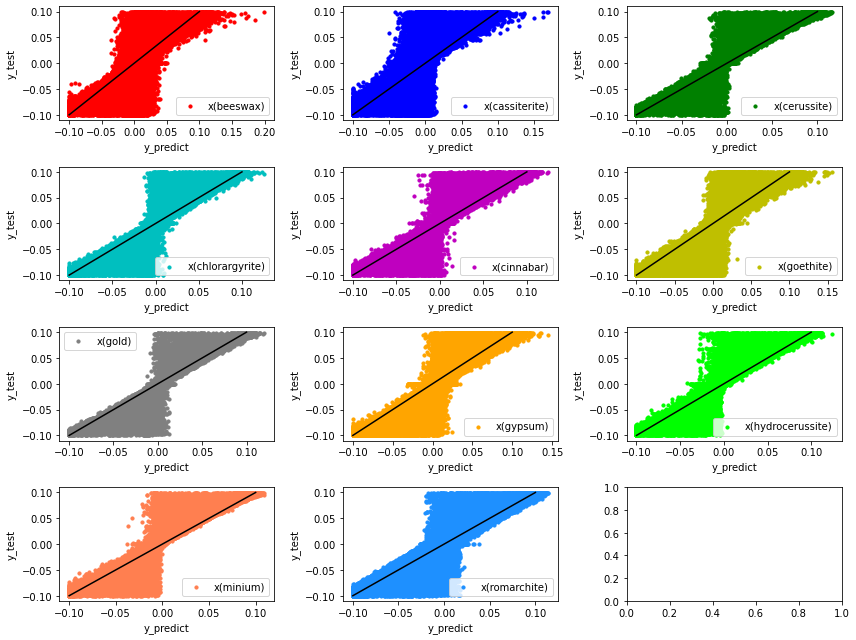

In [12]:
# Prediction of h on val data
model_h = load_model('best_val_loss_model_h.h5')
y_predict_h = model_h.predict( X_val )

colors = ['r', 'b', 'g', 'c', 'm', 'y', 'gray', 'orange', 'lime', 'coral', 'dodgerblue']
fig,axs = plt.subplots(4,3,figsize=(12,9))
for i in range(n_ph):
    axs = axs.flatten()
    axs[i].plot([-0.1, 0.1], [-0.1, 0.1], color="k")
    axs[i].scatter(y_predict_h[:, i] / factor_multiplier_h - 0.1, 
                   y_val[:, n_ph+i] / factor_multiplier_h - 0.1, 
                   color=colors[i],
                   s=10,
                   label=f"x({dict_ph[i]})")
    axs[i].set_ylabel('y_test')
    axs[i].set_xlabel('y_predict')
    axs[i].legend()

plt.tight_layout()
# plt.savefig('all_h.png', bbox_inches='tight', dpi=1200)

## Prediction on experimental data

In [4]:
file = h5py.File('S2018_157_sinogram_layer02_XRD_powder_pack_half1_short-iback_clean.h5', 'r')
print(f"Dataset keys: {file.keys()}")

# Load the real data to work on
real_data_S157 = np.array(file['data/data'])
# Extract the number of translation and rotation
t = real_data_S157.shape[0]
r = real_data_S157.shape[1]
# Real data are shaped as a 2D array instead of 3D for ease of use (in some cases)
real_data_S157_reshaped = real_data_S157.reshape(r*t, real_data_S157.shape[2])

print(f"\nExperimental dataset shape: {real_data_S157.shape}")
theta_range_S157 = np.array(file['data/theta']) # Extract theta range from h5 file


# Here, some other specs are in another h5 file like mask and contour
filec = h5py.File('S2018_157_sinogram_layer02_XRD_powder_pack_half1-back_clean_corr_mask.h5', 'r')
mask_S157 = np.array(filec['recons/mask'])
cont_S157 = np.array(filec['recons/contour'])

Dataset keys: <KeysViewHDF5 ['2theta', 'data']>

Experimental dataset shape: (82, 90, 2150)


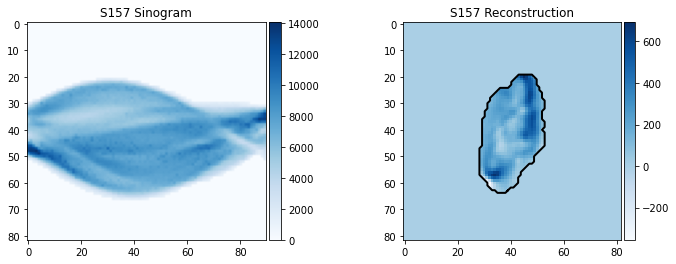

In [5]:
# Plot of sinograms and reconstruction
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
im1 = plt.imshow(np.sum(real_data_S157, 2), cmap='Blues', aspect='equal')
plt.title("S157 Sinogram")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)


plt.subplot(1, 2, 2)
recons=mask_S157 * iradon(np.sum(real_data_S157, 2), theta=theta_range_S157, circle=True, interpolation='linear', filter_name='cosine')
im2 = plt.imshow(recons, cmap='Blues', interpolation='none')
plt.plot(cont_S157[:, 1], cont_S157[:, 0], linewidth=2, color='black')
plt.title("S157 Reconstruction")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

In [6]:
# =============================================================================
#     Normalisation before prediction with NN
# =============================================================================
# Keep scale factors for total semi-quanti afterwards
scale_factors = np.zeros((real_data_S157_reshaped.shape[0], 1))

for i in range(real_data_S157_reshaped.shape[0]):
    rowmax = np.max(real_data_S157_reshaped[i])
    scale_factors[i,0] = rowmax
    if rowmax == 0:
        continue # avoid calculations where there is no pattern i.e. "outside" the sinogram
    else:
        real_data_S157_reshaped[i] = real_data_S157_reshaped[i] / rowmax

In [7]:
# =============================================================================
#     Predictions on real data
# =============================================================================
start = time.time()

model_pp = load_model("best_val_loss_model_pp_article.h5")
model_h = load_model("best_val_loss_model_h_article.h5")

real_data_S157_pp = model_pp.predict(real_data_S157_reshaped)
real_data_S157_h = model_h.predict(real_data_S157_reshaped)

end = time.time()

print(f'Prediction time: {int(end-start)//60} minutes {int(end-start)%60} seconds\n')

# Prediction outputs need to be divided by their multiplier factors (and offset for h)
real_data_S157_pp = real_data_S157_pp / factor_multiplier_pp
real_data_S157_h = real_data_S157_h / factor_multiplier_h - 0.1

# Delete the prediction that can be made on null patterns
real_data_S157_pp[np.sum(real_data_S157_reshaped, axis=1) == 0, :] = 0
real_data_S157_h[np.sum(real_data_S157_reshaped, axis=1) == 0, :] = 0

# In every pixel of the sinogram: sum of phase fractions == 1
for i in range(real_data_S157_pp.shape[0]):
    tot = np.sum(real_data_S157_pp[i,:])
    if tot == 0:
        continue
    else:
        for j in range(real_data_S157_pp.shape[1]):
            real_data_S157_pp[i,j] = real_data_S157_pp[i,j] / tot

# All pixel is scaled by its scale factor from previous normalisation
real_data_S157_pp_scaled = real_data_S157_pp * scale_factors
real_data_S157_pp_scaled = real_data_S157_pp_scaled.reshape(t, r, len(dict_ph))

# The dataset is reshaped as 3D array with similar shape of real data from h5
    # except that the 3rd dimension = number of phases
real_data_S157_pp = real_data_S157_pp.reshape(t, r, len(dict_ph))
real_data_S157_h = real_data_S157_h.reshape(t, r, len(dict_ph))

# display S-Q calculation            
for i in range (len(dict_ph)):
    print(f"{dict_ph[i]}: {np.round(100 * sum(sum(real_data_S157_pp_scaled[:,:,i])) / sum(sum(sum(real_data_S157_pp_scaled))), 1)}%")

231/231 [==============================] - 1s 2ms/step
Prediction time: 0 minutes 2 seconds

beeswax: 20.8%
cassiterite: 9.7%
cerussite: 0.7%
chlorargyrite: 0.6%
cinnabar: 9.3%
goethite: 6.6%
gold: 0.4%
gypsum: 42.6%
hydrocerussite: 1.3%
minium: 0.1%
romarchite: 7.9%


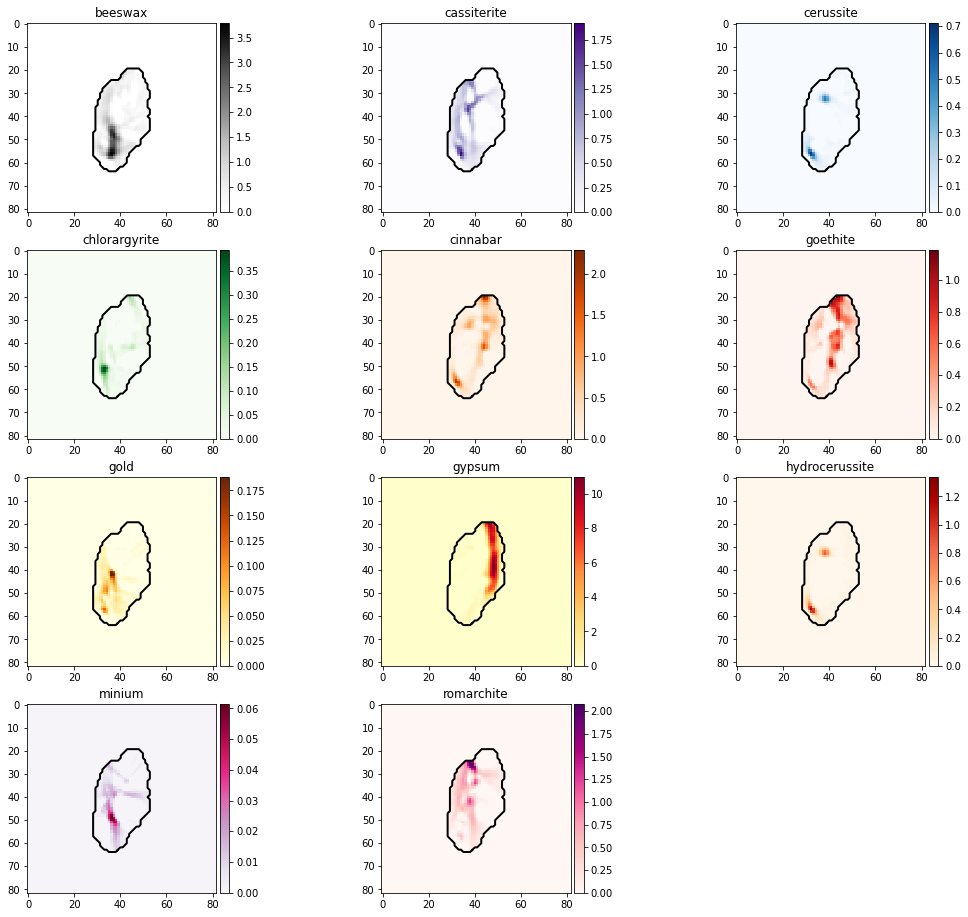

In [13]:
# Plot of the phases fractions maps for each phase as reconstructions
recons_pp_tot = np.empty((t, t, 0), float)

for i in range(len(dict_ph)):    
    recons_pp = mask_S157 * iradon(real_data_S157_pp_scaled[:, :, i], theta=theta_range_S157, circle=True, interpolation='linear', filter_name='cosine')
    recons_pp[recons_pp<0] = 0
    recons_pp = recons_pp.reshape(82, 82, 1)
    recons_pp_tot = np.append(recons_pp_tot, recons_pp, axis=2)

fig = plt.figure(figsize=(18,16))

cmap_color = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu']

for i in range(len(dict_ph)):    
    plt.subplot(4, 3, i+1)
    im = plt.imshow(recons_pp_tot[:, :, i], cmap=cmap_color[i], interpolation='none')
    plt.plot(cont_S157[:, 1], cont_S157[:, 0], linewidth=2, color='black')
    
    plt.title(f"{dict_ph[i]}")
    
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

## Rebuilding the patterns from pp and h predictions

In [8]:
if __name__ == "__main__":
    
    y_predict_pp = real_data_S157_pp.reshape(r*t, n_ph)
    y_predict_h = real_data_S157_h.reshape(r*t, n_ph)    
    
    n_processes = cpu_count()
    print("Starting drx pattern regeneration on "+str(n_processes)+" CPUs")
    start = time.time()
    
    args = zip(itertools.repeat(list_tth), itertools.repeat(list_db), 
                itertools.repeat(list_icor), y_predict_pp, y_predict_h)
    with Pool(processes=n_processes) as proc_pool:
        results = proc_pool.starmap(MP_Pattern_rebuilding, tqdm(args, total=len(y_predict_pp)))
            
    # =============================================================================
    #     Concatenate the results to form one numpy array
    # =============================================================================
    dataset_rebuilt = np.empty((0, length_list), float)
    for res in results:
        dataset_rebuilt = np.append(dataset_rebuilt, res, axis=0)

    # =============================================================================
    #     Writing the dataset into a pickle file
    # =============================================================================        
    with open("patterns_rebuilt_test.pickle", "wb") as output_file:
        cPickle.dump([dataset_rebuilt], output_file)
        
    print("Shape du dataset :", dataset_rebuilt.shape)
    
    # Print the creation time of the dataset
    end = time.time()
    tps = int(end - start)
    print("Temps : ", tps//60, 'minutes', tps%60, 'secondes')
    # Print the number of error in the dataset
    print("Nombre d'erreur :", np.isnan(dataset_rebuilt).sum())

Starting drx pattern regeneration on 40 CPUs


100%|██████████| 7380/7380 [00:02<00:00, 2962.11it/s] 


KeyboardInterrupt: 

In [14]:
with open("patterns_rebuilt_S157.pickle", "rb") as input_file:
    dataset_rebuilt = cPickle.load(input_file)[0]

Rwp_reshaped = []

for i in range(real_data_S157_reshaped.shape[0]):
    if sum(real_data_S157_reshaped[i,:]) < 1e-12:
        Rwp_reshaped = np.append(Rwp_reshaped, [0], axis=0)
    else:
        rwp = Rwp(real_data_S157_reshaped[i,:], dataset_rebuilt[i,:])
        Rwp_reshaped = np.append(Rwp_reshaped, [rwp], axis=0)

print(f"Moyenne du Rwp :{np.mean(Rwp_reshaped[np.where(Rwp_reshaped != 0)])}")

Moyenne du Rwp :59.72280887527144


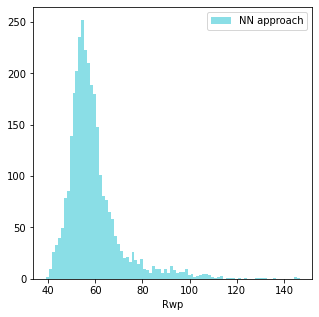

In [15]:
Rwp_NN = Rwp_reshaped[(Rwp_reshaped>0) & (Rwp_reshaped<150)]

plt.close()
plot = plt.figure(figsize=(5, 5))
plt.hist(Rwp_NN, bins=86, alpha=0.5, color='tab:cyan', label='NN approach')
plt.xlabel('Rwp')
plt.legend()
plt.show()